In [ ]:
!pip install wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import wandb
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb


In [ ]:
!curl -sSLO https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip -q nature_12K.zip
train_dir='inaturalist_12K/train/' # all these info from provided dataset
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

(300, 300, 3)


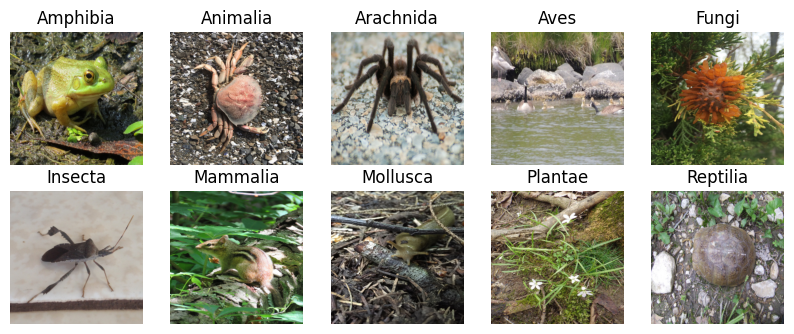

In [ ]:
rows = 5
cols = 5
fig = plt.figure(figsize = (10,10))
i=1
for c in classes:
  class_dir=os.path.join(train_dir,c)
  for img in os.listdir(class_dir):
    img_path=os.path.join(class_dir,img)
    image=mpimg.imread(img_path)
    new_img=cv2.resize(image,(300,300))
    fig.add_subplot(rows,cols,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(c)
    i=i+1
    break
print(new_img.shape)


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def prepare_dataset(batch_size=32):
    train_dir = 'inaturalist_12K/train/'
    test_dir = 'inaturalist_12K/val/'

    # Define transformations (rescale, resize, convert to tensor, normalize)
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # Resize images to 300x300
        transforms.ToTensor(),  # Convert images to PyTorch tensors (C, H, W) format
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])

    # Load datasets
    full_train_data = datasets.ImageFolder(root=train_dir, transform=transform)


    train_size = int(0.8 * len(full_train_data))
    val_size = len(full_train_data) - train_size
    train_data, val_data = torch.utils.data.random_split(full_train_data, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader,val_loader


In [ ]:
prepare_dataset()

(<torch.utils.data.dataloader.DataLoader at 0x78e25c0177d0>,
 <torch.utils.data.dataloader.DataLoader at 0x78e25c0702d0>)

                                                                       
                                                                        
                                                                         
                                                                          
                                                                           
#                                                                               Part A: Training from scratch
                                                                             
                                                                                                         

Question 1 (5 Marks)--Build a small CNN model consisting of 5 convolution layers.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FiveLayerCNN(nn.Module):
    def __init__(self, no_of_filters, size_of_filters, activation_function, number_of_neurons_in_the_dense_layer):
        super(FiveLayerCNN, self).__init__()

        # Define activation functions
        activations = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(),
            'softmax': nn.Softmax(dim=1)
        }

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, no_of_filters[0], size_of_filters[0], padding='same')
        self.conv2 = nn.Conv2d(no_of_filters[0], no_of_filters[1], size_of_filters[1], padding='same')
        self.conv3 = nn.Conv2d(no_of_filters[1], no_of_filters[2], size_of_filters[2], padding='same')
        self.conv4 = nn.Conv2d(no_of_filters[2], no_of_filters[3], size_of_filters[3], padding='same')
        self.conv5 = nn.Conv2d(no_of_filters[3], no_of_filters[4], size_of_filters[4], padding='same')

        # Activation functions
        self.act1 = activations[activation_function[0]]
        self.act2 = activations[activation_function[1]]
        self.act3 = activations[activation_function[2]]
        self.act4 = activations[activation_function[3]]
        self.act5 = activations[activation_function[4]]
        self.dense_act = activations[activation_function[5]]
        self.output_act = activations[activation_function[6]]

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(no_of_filters[4] * 9 * 9, number_of_neurons_in_the_dense_layer)  # Assuming 300x300 input
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(number_of_neurons_in_the_dense_layer, 10)  # Output layer with 10 classes

    def forward(self, x):
        x = self.pool(self.act1(self.conv1(x)))
        x = self.pool(self.act2(self.conv2(x)))
        x = self.pool(self.act3(self.conv3(x)))
        x = self.pool(self.act4(self.conv4(x)))
        x = self.pool(self.act5(self.conv5(x)))

        x = self.flatten(x)
        x = self.dense_act(self.fc1(x))
        x = self.dropout(x)
        x = self.output_act(self.fc2(x))

        return x


In [ ]:
# Define model parameters
no_of_filters = [32, 64, 128, 256, 512]
size_of_filters = [3, 3, 3, 3, 3]
activation_function = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'softmax']
number_of_neurons_in_the_dense_layer = 128

# Create the model
model = FiveLayerCNN(no_of_filters, size_of_filters, activation_function, number_of_neurons_in_the_dense_layer)

# Check model architecture
print(model)


FiveLayerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act1): ReLU()
  (act2): ReLU()
  (act3): ReLU()
  (act4): ReLU()
  (act5): ReLU()
  (dense_act): ReLU()
  (output_act): Softmax(dim=1)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=41472, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


you can confirm how the model asked runs by running code block below

In [ ]:
# Move model to GPU if available
train_loader, val_loader = prepare_dataset()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():  # Disable gradient calculations for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f} - Accuracy: {train_accuracy:.4f} - Val_Loss: {avg_val_loss:.4f} - Val_Accuracy: {val_accuracy:.4f}")



*********************************************************************************************************************************************************************************************************************************

*********************************************************************************************************************************************************************************************************************************

*********************************************************************************************************************************************************************************************************************************

*********************************************************************************************************************************************************************************************************************************

**Question 2 (15 Marks)**-train  model using the iNaturalist dataset and wandbi sweep feature

In [ ]:
# this is the code for data preparation

from torch.utils.data import random_split

def preparing_data(batch_size=32, augment=True):
    train_dir = 'inaturalist_12K/train/'
    test_dir = 'inaturalist_12K/val/'

    # Define transforms
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    val_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])




    test_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()

    ])
    # Load datasets
    train_val_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

    # Split train into 80% train, 20% val
    train_size = int(0.8 * len(train_val_data))
    val_size = len(train_val_data) - train_size
    train_data, val_data = random_split(train_val_data, [train_size, val_size])

    # Apply val_transform to validation set
    val_data.dataset.transform = val_transform

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)

    # Print dataset sizes
    print(f"Training images: {len(train_data)}")
    print(f"Validation images: {len(val_data)}")
    print(f"Test images: {len(test_data)}")
    print(f"Number of classes: {len(train_val_data.classes)}")

    return train_loader, val_loader, test_loader, len(train_val_data.classes)


In [ ]:
# this is the code for creating a model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast  # Updated import
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

class CNN(nn.Module):
    def __init__(self, config, input_size=128):
        super(CNN, self).__init__()

        # Build convolutional layers
        layers = []
        in_channels = 3
        filter_sizes = [int(config.first_layer_filters * (config.filter_org ** i))
                       for i in range(5)]  # Using 5 conv layers as per your config

        for filters in filter_sizes:
            layers.extend([
                nn.Conv2d(in_channels, filters, config.kernel_size, padding=1),
                nn.BatchNorm2d(filters) if config.batch_norm else nn.Identity(),
                nn.ReLU(),
                nn.MaxPool2d(2)
            ])
            in_channels = filters

        self.conv_layers = nn.Sequential(*layers)

        # Calculate flattened size
        with torch.no_grad():
            dummy = torch.randn(1, 3, input_size, input_size)
            dummy_out = self.conv_layers(dummy)
            self.flattened_size = dummy_out.numel() // dummy_out.shape[0]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, config.dense_size),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.dense_size, config.num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
def train_model(config=None, testing_mode=False):
    with wandb.init(config=config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model = CNN(config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        scaler = GradScaler()  # Updated
        # scaler = GradScaler(device_type='cuda')  # Updated



        for epoch in range(config.num_epochs):
          model.train()
          train_loss, correct = 0, 0

          for images, labels in train_data:
              images, labels = images.to(device), labels.to(device)

              optimizer.zero_grad()
              with autocast(device_type='cuda'):  # Updated
                  outputs = model(images)
                  loss = criterion(outputs, labels)

              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()

              train_loss += loss.item()
              correct += (outputs.argmax(1) == labels).sum().item()

          # Validation
          model.eval()
          val_loss, val_correct = 0, 0
          with torch.no_grad(), autocast(device_type='cuda'):
              for images, labels in val_data:
                  images, labels = images.to(device), labels.to(device)
                  outputs = model(images)
                  val_loss += criterion(outputs, labels).item()
                  val_correct += (outputs.argmax(1) == labels).sum().item()

          # Log metrics
          wandb.log({
              "epoch": epoch,
              "train_loss": train_loss/len(train_data),
              "train_acc": correct/len(train_data.dataset),
              "val_loss": val_loss/len(val_data),
              "val_acc": val_correct/len(val_data.dataset)
          })

          print(f"Epoch {epoch+1}/{config.num_epochs} | "
                f"Train Loss: {train_loss/len(train_data):.4f} | "
                f"Val Acc: {val_correct/len(val_data.dataset):.4f}")

        if testing_mode:
          model.eval()
          test_loss, test_correct = 0, 0
          with torch.no_grad():
              for images, labels in test_data:
                  images, labels = images.to(device), labels.to(device)
                  outputs = model(images)
                  test_loss += criterion(outputs, labels).item()
                  test_correct += (outputs.argmax(1) == labels).sum().item()

          print(f"Test Accuracy: {test_correct/len(test_data.dataset):.4f}")






#

In [ ]:
# Initialize data (make sure this matches your actual dataset)
train_data, val_data, test_data, num_classes = preparing_data(batch_size=32, augment=True)

Training images: 7999
Validation images: 2000
Test images: 2000
Number of classes: 10


In [ ]:

# sweep configurations


sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'first_layer_filters': {'values': [32, 64]},
        'filter_org': {'values': [0.5, 1, 2]},
        'data_aug': {'values': [False, True]},
        'batch_norm': {'values': [True]},
        'dropout': {'values': [0.0, 0.2, 0.3]},
        'kernel_size': {'values': [3, 5]},
        'dense_size': {'values': [32, 64, 128]},
        'num_epochs': {'values': [10]},
        'num_classes': {'values': [num_classes]},  # Dynamic class count
    }
}

sweep_config['parameters']['num_classes'] = {'values': [num_classes]}

sweep_id = wandb.sweep(sweep_config, project='cnn')
wandb.agent(sweep_id, function=train_model)

*********************************************************************************************************************************************************************************************************************************

*********************************************************************************************************************************************************************************************************************************

*********************************************************************************************************************************************************************************************************************************

*********************************************************************************************************************************************************************************************************************************

Question 4 (5 Marks)---Training the model and evaluating on test data

In [ ]:
from types import SimpleNamespace

def train_model(config=None, wandbi=True):
    if wandbi:
        wandb_run = wandb.init(config=config)
        config = wandb.config
    else:
        wandb_run = None
        config = SimpleNamespace(**config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    for epoch in range(config.num_epochs):
        model.train()
        train_loss, correct = 0, 0

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad(), autocast(device_type='cuda'):
            for images, labels in val_data:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        if wandbi:
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss / len(train_data),
                "train_acc": correct / len(train_data.dataset),
                "val_loss": val_loss / len(val_data),
                "val_acc": val_correct / len(val_data.dataset)
            })

        print(f"Epoch {epoch+1}/{config.num_epochs} | "
              f"Train Loss: {train_loss/len(train_data):.4f} | "
              f"Val Acc: {val_correct/len(val_data.dataset):.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "model.pth")
    print("Model saved to model.pth")

    if wandbi:
        wandb_run.finish()


In [ ]:
def test_model(config):
    config = SimpleNamespace(**config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(config).to(device)

    # Load trained weights
    model.load_state_dict(torch.load("model.pth", map_location=device))
    model.eval()

    criterion = nn.CrossEntropyLoss()
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for images, labels in test_data:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            test_correct += (outputs.argmax(1) == labels).sum().item()

    print(f"Test Accuracy: {test_correct/len(test_data.dataset):.4f}")


Question 4a-Use the best model from your sweep and report the accuracy on the test set

In [ ]:
best_config = {
              'first_layer_filters': 64,
              'filter_org': 1,
              'data_aug': True,
              'batch_norm': True,
              'dropout': 0.3,
              'kernel_size': 5,
              'dense_size': 128,
              'activation': 'relu',
              'num_epochs': 10,
              'optimizer': 'adam',
              'conv_layers': 5,
              'num_classes':10,
          }

In [ ]:
train_model(config=best_config, wandbi=False)


Epoch 1/10 | Train Loss: 2.1695 | Val Acc: 0.2400
Epoch 2/10 | Train Loss: 2.0758 | Val Acc: 0.2605
Epoch 3/10 | Train Loss: 2.0116 | Val Acc: 0.2775
Epoch 4/10 | Train Loss: 1.9531 | Val Acc: 0.3140
Epoch 5/10 | Train Loss: 1.9178 | Val Acc: 0.3190
Epoch 6/10 | Train Loss: 1.8592 | Val Acc: 0.3145
Epoch 7/10 | Train Loss: 1.8138 | Val Acc: 0.3430
Epoch 8/10 | Train Loss: 1.7598 | Val Acc: 0.3295
Epoch 9/10 | Train Loss: 1.7009 | Val Acc: 0.3620
Epoch 10/10 | Train Loss: 1.6420 | Val Acc: 0.3340
✅ Model saved to model.pth


In [ ]:
test_model(best_config)

🧪 Test Accuracy: 0.3455


Question 4b-Provide a 10×3 grid containing sample images from the test data and predictions made by your best model

In [ ]:
from types import SimpleNamespace

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap dict into SimpleNamespace so attributes work with dot notation
config = SimpleNamespace(**best_config)

model = CNN(config).to(device)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


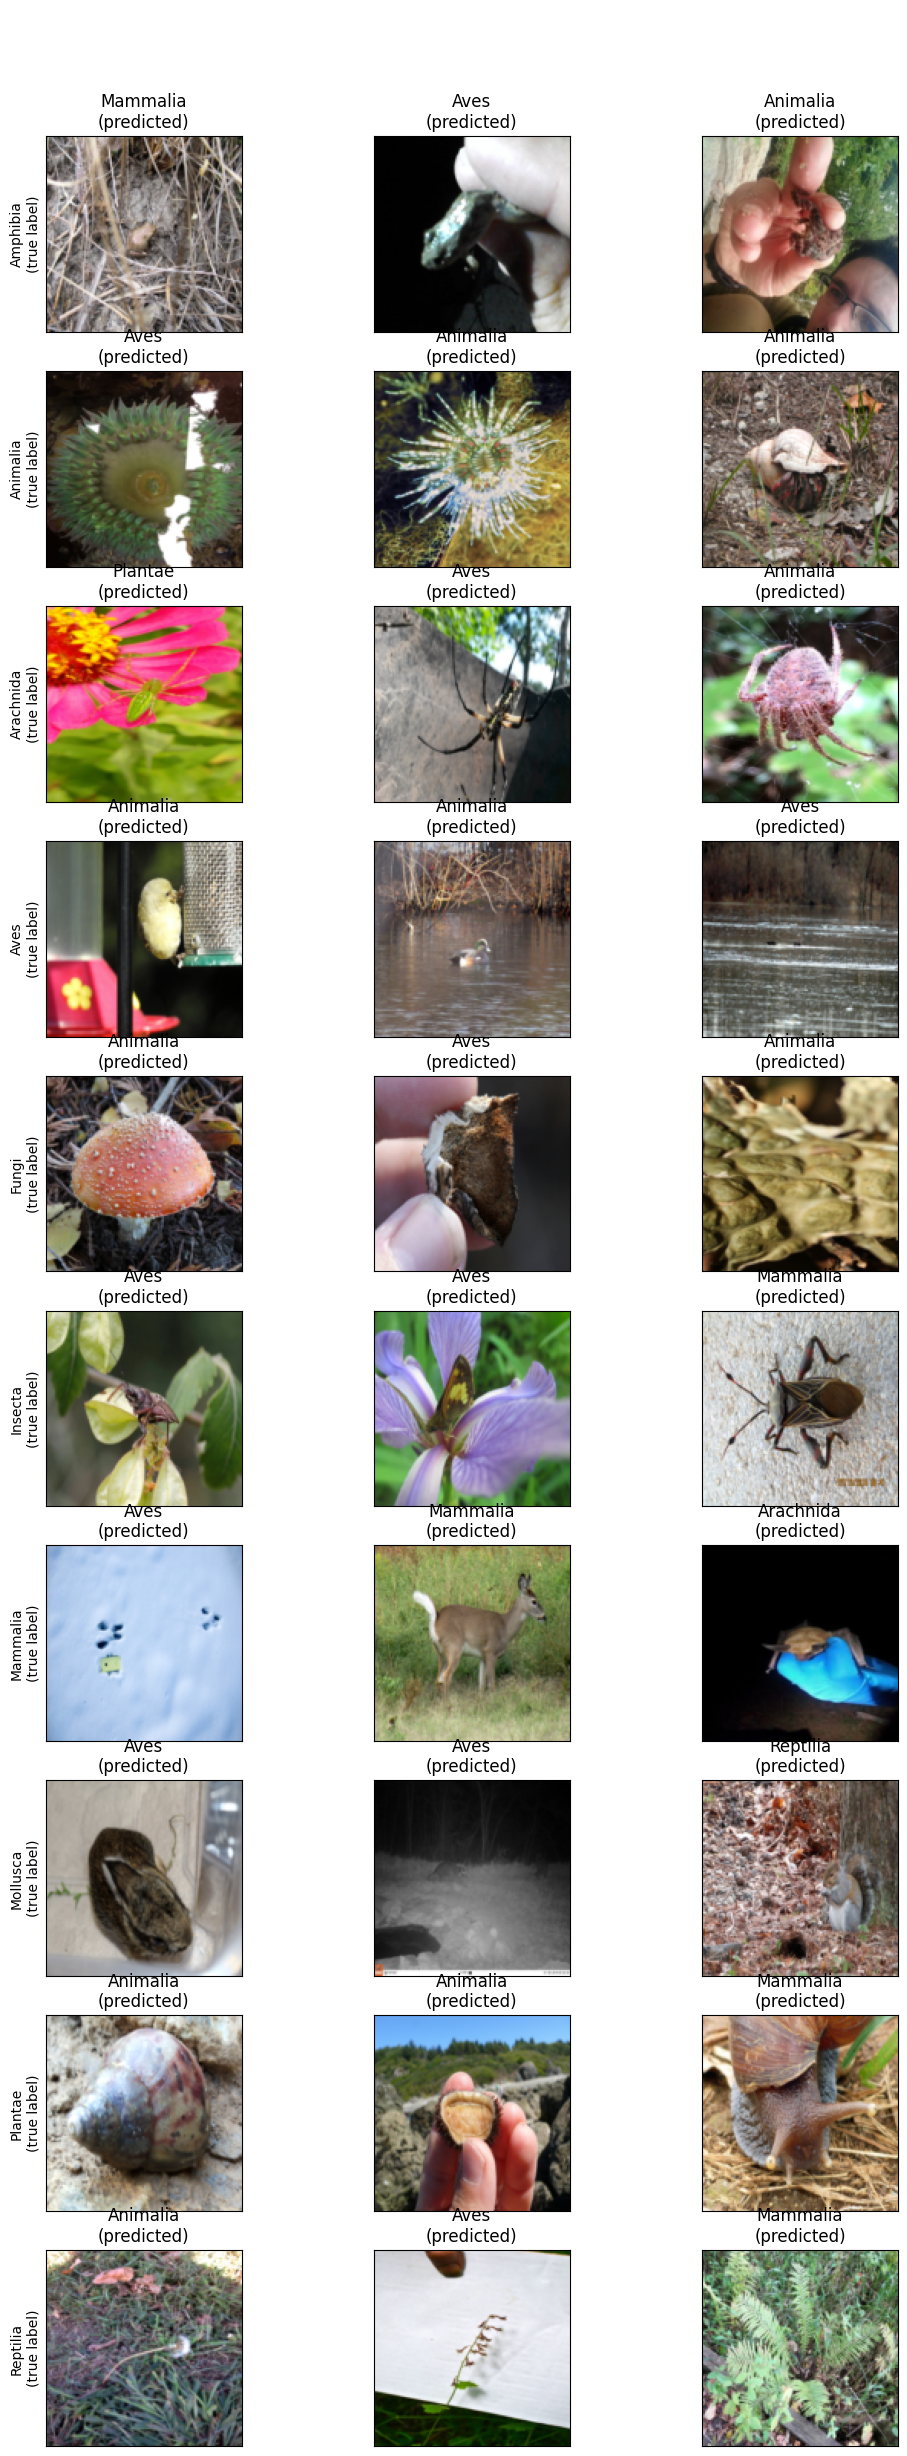

In [ ]:
wandb.init(project='cnn')

labels_list = test_data.dataset.classes
print(labels_list)


batches_show = [0, 7, 13, 19, 25, 32, 38, 42, 48, 55]

fig, axs = plt.subplots(10, 3, figsize=(12, 30))
class_count = 0

for batch_count, (data, label) in enumerate(test_data):
    if batch_count in batches_show and class_count < 10:  # Ensure we don't exceed subplots
        axs[class_count, 0].set(ylabel=f'{labels_list[class_count]}\n(true label)')

        for i in range(3):
            image = np.array(data[i].permute(1, 2, 0))  # CHW → HWC

            # Rescale from [-1, 1] to [0, 1]
            image = (image - image.min()) / (image.max() - image.min())

            input_tensor = data[i].unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)

            pred_idx = output.argmax(1).item()
            predicted_lab = labels_list[pred_idx]

            axs[class_count, i].imshow(image)
            axs[class_count, i].set_title(f'\n\n\n\n{predicted_lab}\n(predicted)')
            axs[class_count, i].set_xticks([])
            axs[class_count, i].set_yticks([])

        class_count += 1

    if class_count >= 10:  # Stop after plotting all classes
        break

wandb.log({'img_display_Q4': [wandb.Image(fig)]})
# plt.close(fig)
# bfa906d266650bc7eeb24f630ce178ff8ead3a2d

**************************************************************************

********************************************************************************

*********************************************************************************************************************************************************************************************************************************

*****************************************************************************************************************************************************

**Part B : Fine-tuning a pre-trained model**

In [ ]:
from torch.utils.data import random_split

def preparing_data(batch_size=32, augment=True):
    train_dir = 'inaturalist_12K/train/'
    test_dir = 'inaturalist_12K/val/'

    # Define transforms
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((299,299)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((299,299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    val_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])



    test_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor()

    ])
    # Load datasets
    train_val_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

    # Split train into 80% train, 20% val
    train_size = int(0.8 * len(train_val_data))
    val_size = len(train_val_data) - train_size
    train_data, val_data = random_split(train_val_data, [train_size, val_size])

    # Apply val_transform to validation set
    val_data.dataset.transform = val_transform

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)

    # Print dataset sizes
    print(f"Training images: {len(train_data)}")
    print(f"Validation images: {len(val_data)}")
    print(f"Test images: {len(test_data)}")
    print(f"Number of classes: {len(train_val_data.classes)}")

    return train_loader, val_loader, test_loader, len(train_val_data.classes)

In [ ]:
train_data, val_data, test_data, num_classes = preparing_data(batch_size=32, augment=True)

Training images: 7999
Validation images: 2000
Test images: 2000
Number of classes: 10


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNN(nn.Module):
    def __init__(self, base_model_name="ResNet50", tune=False, offset=20):
        super(CNN, self).__init__()
        self.base_model_name = base_model_name
        self.tune = tune
        self.offset = offset

        self.init_base_model()

        # Final classification layer
        self.additional_dense1 = nn.Linear(self.base_out_features, 10)

        # Only needed for ResNet (Inception gives [B, 2048] already)
        if self.base_model_name != "InceptionV3":
            self.additional_avg_pool1 = nn.AdaptiveAvgPool2d((1, 1))

    def init_base_model(self):
        if self.base_model_name == "InceptionV3":
            base = models.inception_v3(pretrained=True, aux_logits=True)
            self.base_model = base
            self.base_model.fc = nn.Identity()
            self.base_out_features = 2048

        elif self.base_model_name == "ResNet50":
            base = models.resnet50(pretrained=True)
            self.base_model = nn.Sequential(*list(base.children())[:-2])
            self.base_out_features = 2048

        else:
            raise ValueError(f"{self.base_model_name} not supported. Use ResNet50 or InceptionV3.")

        # Freezing or partial fine-tuning
        if not self.tune:
            for param in self.base_model.parameters():
                param.requires_grad = False
        else:
            for i, (name, param) in enumerate(self.base_model.named_parameters()):
                if i < self.offset:
                    param.requires_grad = False




    def forward(self, x):
        if self.base_model_name == "InceptionV3":
            x = self.base_model(x)
            if isinstance(x, tuple) or hasattr(x, "logits"):
                x = x.logits  # <-- Fix: extract logits from InceptionOutputs
        else:
            x = self.base_model(x)            # [B, 2048, H, W]
            x = self.additional_avg_pool1(x)  # [B, 2048, 1, 1]
            x = torch.flatten(x, 1)           # [B, 2048]

        x = self.additional_dense1(x)         # [B, 10]
        return x


In [ ]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast
from types import SimpleNamespace

def pretrain_CNN_sweep(config=None, use_wandbi=True):
    if use_wandbi:
        wandb_run = wandb.init(config=config)
        config = wandb.config
    else:
        wandb_run = None
        default_config = {
            'base_model_name': 'ResNet50',
            'tune': True,
            'data_aug': False,

        }
        config = SimpleNamespace(**default_config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(base_model_name=config.base_model_name, tune=config.tune).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()



    for i in range(10):
        model.train()
        train_loss, correct = 0.0, 0

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_data.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad(), autocast(device_type='cuda'):
            for images, labels in val_data:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_data.dataset)

        if use_wandbi:
            wandb.log({
                'epoch': i + 1,
                'train_loss': train_loss / len(train_data),
                'train_acc': train_acc,
                'val_loss': val_loss / len(val_data),
                'val_acc': val_acc
            })

        print(f"Epoch {i+1}/{10} | "
              f"Train Loss: {train_loss/len(train_data):.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), "model.pth")
    print("Model saved to model.pth")

    if use_wandbi:
        wandb_run.finish()


In [ ]:
sweep_config = {'name': 'random-test-sweep', 'method': 'grid'}
sweep_config['metric'] = {'name': 'val_acc', 'goal': 'maximize'}
parameters_dict = {
                   'base_model_name': {'values': ["InceptionV3","ResNet50"]},
                   'tune': {'values': [False, True]},
                   'data_aug': {'values': [False, True]}
                  }
sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'cnn_part_B')
wandb.agent(sweep_id, function=pretrain_CNN_sweep)

Create sweep with ID: wv9wuqaf
Sweep URL: https://wandb.ai/duenchombo1-indian-institute-of-technology-madras/cnn_part_B/sweeps/wv9wuqaf


wandb: Agent Starting Run: lyfmz8y1 with config:
wandb: 	base_model_name: InceptionV3
wandb: 	data_aug: False
wandb: 	tune: False


<ipython-input-34-df6ffc3b50a2>:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10 | Train Loss: 2.0693 | Train Acc: 0.3447 | Val Acc: 0.6330
Epoch 2/10 | Train Loss: 1.6544 | Train Acc: 0.5969 | Val Acc: 0.6945
Epoch 3/10 | Train Loss: 1.4015 | Train Acc: 0.6627 | Val Acc: 0.7045
Epoch 4/10 | Train Loss: 1.2605 | Train Acc: 0.6781 | Val Acc: 0.7170
Epoch 5/10 | Train Loss: 1.1654 | Train Acc: 0.6857 | Val Acc: 0.7205
Epoch 6/10 | Train Loss: 1.0952 | Train Acc: 0.6956 | Val Acc: 0.7245
Epoch 7/10 | Train Loss: 1.0491 | Train Acc: 0.7028 | Val Acc: 0.7225
Epoch 8/10 | Train Loss: 1.0141 | Train Acc: 0.7052 | Val Acc: 0.7265
Epoch 9/10 | Train Loss: 0.9790 | Train Acc: 0.7158 | Val Acc: 0.7305
Epoch 10/10 | Train Loss: 0.9573 | Train Acc: 0.7198 | Val Acc: 0.7345
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▅▆▇▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_acc,0.71984
train_loss,0.9573
val_acc,0.7345
val_loss,0.92195


wandb: Agent Starting Run: 3222qcmg with config:
wandb: 	base_model_name: InceptionV3
wandb: 	data_aug: False
wandb: 	tune: True


Epoch 1/10 | Train Loss: 0.9106 | Train Acc: 0.7208 | Val Acc: 0.7790
Epoch 2/10 | Train Loss: 0.3511 | Train Acc: 0.8947 | Val Acc: 0.7950
Epoch 3/10 | Train Loss: 0.1628 | Train Acc: 0.9520 | Val Acc: 0.8100
Epoch 4/10 | Train Loss: 0.0986 | Train Acc: 0.9702 | Val Acc: 0.8000
Epoch 5/10 | Train Loss: 0.0936 | Train Acc: 0.9740 | Val Acc: 0.7945
Epoch 6/10 | Train Loss: 0.0806 | Train Acc: 0.9750 | Val Acc: 0.7790
Epoch 7/10 | Train Loss: 0.0776 | Train Acc: 0.9751 | Val Acc: 0.7865
Epoch 8/10 | Train Loss: 0.0704 | Train Acc: 0.9799 | Val Acc: 0.7950
Epoch 9/10 | Train Loss: 0.0620 | Train Acc: 0.9812 | Val Acc: 0.7910
Epoch 10/10 | Train Loss: 0.0451 | Train Acc: 0.9870 | Val Acc: 0.7935
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇███████
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▁▅█▆▅▁▃▅▄▄
val_loss,▂▁▂▃▅▇█▆▇█
epoch,10
train_acc,0.987
train_loss,0.0451
val_acc,0.7935
val_loss,0.89539


wandb: Agent Starting Run: p8cvbg73 with config:
wandb: 	base_model_name: InceptionV3
wandb: 	data_aug: True
wandb: 	tune: False


Epoch 1/10 | Train Loss: 2.0739 | Train Acc: 0.3415 | Val Acc: 0.6275
Epoch 2/10 | Train Loss: 1.6543 | Train Acc: 0.5989 | Val Acc: 0.6815
Epoch 3/10 | Train Loss: 1.4054 | Train Acc: 0.6595 | Val Acc: 0.6885
Epoch 4/10 | Train Loss: 1.2560 | Train Acc: 0.6796 | Val Acc: 0.7125
Epoch 5/10 | Train Loss: 1.1560 | Train Acc: 0.6993 | Val Acc: 0.7185
Epoch 6/10 | Train Loss: 1.0934 | Train Acc: 0.6942 | Val Acc: 0.7270
Epoch 7/10 | Train Loss: 1.0423 | Train Acc: 0.7026 | Val Acc: 0.7250
Epoch 8/10 | Train Loss: 1.0090 | Train Acc: 0.7131 | Val Acc: 0.7265
Epoch 9/10 | Train Loss: 0.9836 | Train Acc: 0.7061 | Val Acc: 0.7380
Epoch 10/10 | Train Loss: 0.9666 | Train Acc: 0.7137 | Val Acc: 0.7315
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇██████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_acc,0.71371
train_loss,0.96661
val_acc,0.7315
val_loss,0.92684


wandb: Agent Starting Run: xi3g8r63 with config:
wandb: 	base_model_name: InceptionV3
wandb: 	data_aug: True
wandb: 	tune: True


Epoch 1/10 | Train Loss: 0.9229 | Train Acc: 0.7192 | Val Acc: 0.7850
Epoch 2/10 | Train Loss: 0.3630 | Train Acc: 0.8887 | Val Acc: 0.7995
Epoch 3/10 | Train Loss: 0.1714 | Train Acc: 0.9516 | Val Acc: 0.8000
Epoch 4/10 | Train Loss: 0.1034 | Train Acc: 0.9702 | Val Acc: 0.8000
Epoch 5/10 | Train Loss: 0.0794 | Train Acc: 0.9764 | Val Acc: 0.7900
Epoch 6/10 | Train Loss: 0.0818 | Train Acc: 0.9769 | Val Acc: 0.7820
Epoch 7/10 | Train Loss: 0.0808 | Train Acc: 0.9759 | Val Acc: 0.7855
Epoch 8/10 | Train Loss: 0.0678 | Train Acc: 0.9784 | Val Acc: 0.7795
Epoch 9/10 | Train Loss: 0.0724 | Train Acc: 0.9770 | Val Acc: 0.7780
Epoch 10/10 | Train Loss: 0.0549 | Train Acc: 0.9832 | Val Acc: 0.7910
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▇███████
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▃███▅▂▃▁▁▅
val_loss,▁▁▂▄▅▇▇▇█▇
epoch,10
train_acc,0.98325
train_loss,0.05493
val_acc,0.791
val_loss,0.91191


wandb: Agent Starting Run: jwmvcw6j with config:
wandb: 	base_model_name: ResNet50
wandb: 	data_aug: False
wandb: 	tune: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Loss: 1.8544 | Train Acc: 0.4731 | Val Acc: 0.6245
Epoch 2/10 | Train Loss: 1.3510 | Train Acc: 0.6642 | Val Acc: 0.6745
Epoch 3/10 | Train Loss: 1.1450 | Train Acc: 0.6946 | Val Acc: 0.6945
Epoch 4/10 | Train Loss: 1.0237 | Train Acc: 0.7175 | Val Acc: 0.7030
Epoch 5/10 | Train Loss: 0.9498 | Train Acc: 0.7272 | Val Acc: 0.7225
Epoch 6/10 | Train Loss: 0.8959 | Train Acc: 0.7391 | Val Acc: 0.7320
Epoch 7/10 | Train Loss: 0.8547 | Train Acc: 0.7508 | Val Acc: 0.7460
Epoch 8/10 | Train Loss: 0.8260 | Train Acc: 0.7507 | Val Acc: 0.7455
Epoch 9/10 | Train Loss: 0.7987 | Train Acc: 0.7631 | Val Acc: 0.7505
Epoch 10/10 | Train Loss: 0.7775 | Train Acc: 0.7633 | Val Acc: 0.7490
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▆▇▇▇████
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▄▅▅▆▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_acc,0.76335
train_loss,0.77751
val_acc,0.749
val_loss,0.78588


wandb: Agent Starting Run: v6zdyhr6 with config:
wandb: 	base_model_name: ResNet50
wandb: 	data_aug: False
wandb: 	tune: True


Epoch 1/10 | Train Loss: 0.8915 | Train Acc: 0.7072 | Val Acc: 0.7705
Epoch 2/10 | Train Loss: 0.3763 | Train Acc: 0.8810 | Val Acc: 0.7790
Epoch 3/10 | Train Loss: 0.1863 | Train Acc: 0.9479 | Val Acc: 0.7545
Epoch 4/10 | Train Loss: 0.1388 | Train Acc: 0.9575 | Val Acc: 0.7595
Epoch 5/10 | Train Loss: 0.0795 | Train Acc: 0.9762 | Val Acc: 0.8010
Epoch 6/10 | Train Loss: 0.0778 | Train Acc: 0.9771 | Val Acc: 0.7720
Epoch 7/10 | Train Loss: 0.1177 | Train Acc: 0.9650 | Val Acc: 0.7320
Epoch 8/10 | Train Loss: 0.0954 | Train Acc: 0.9701 | Val Acc: 0.7505
Epoch 9/10 | Train Loss: 0.0520 | Train Acc: 0.9846 | Val Acc: 0.7620
Epoch 10/10 | Train Loss: 0.0630 | Train Acc: 0.9805 | Val Acc: 0.7410
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▇▇██████
train_loss,█▄▂▂▁▁▂▁▁▁
val_acc,▅▆▃▄█▅▁▃▄▂
val_loss,▁▁▄▄▂▅█▇▆▇
epoch,10
train_acc,0.9805
train_loss,0.06295
val_acc,0.741
val_loss,1.02123


wandb: Agent Starting Run: deicexvs with config:
wandb: 	base_model_name: ResNet50
wandb: 	data_aug: True
wandb: 	tune: False


Epoch 1/10 | Train Loss: 1.8438 | Train Acc: 0.4907 | Val Acc: 0.5950
Epoch 2/10 | Train Loss: 1.3463 | Train Acc: 0.6613 | Val Acc: 0.6840
Epoch 3/10 | Train Loss: 1.1398 | Train Acc: 0.6940 | Val Acc: 0.6880
Epoch 4/10 | Train Loss: 1.0214 | Train Acc: 0.7165 | Val Acc: 0.7215
Epoch 5/10 | Train Loss: 0.9503 | Train Acc: 0.7250 | Val Acc: 0.7270
Epoch 6/10 | Train Loss: 0.8980 | Train Acc: 0.7375 | Val Acc: 0.7395
Epoch 7/10 | Train Loss: 0.8583 | Train Acc: 0.7415 | Val Acc: 0.7385
Epoch 8/10 | Train Loss: 0.8249 | Train Acc: 0.7490 | Val Acc: 0.7500
Epoch 9/10 | Train Loss: 0.8013 | Train Acc: 0.7601 | Val Acc: 0.7550
Epoch 10/10 | Train Loss: 0.7771 | Train Acc: 0.7628 | Val Acc: 0.7545
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▅▅▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_acc,0.76285
train_loss,0.77706
val_acc,0.7545
val_loss,0.78103


wandb: Agent Starting Run: y8yap175 with config:
wandb: 	base_model_name: ResNet50
wandb: 	data_aug: True
wandb: 	tune: True


Epoch 1/10 | Train Loss: 0.8803 | Train Acc: 0.7150 | Val Acc: 0.7700
Epoch 2/10 | Train Loss: 0.3629 | Train Acc: 0.8846 | Val Acc: 0.7725
Epoch 3/10 | Train Loss: 0.1899 | Train Acc: 0.9439 | Val Acc: 0.7735
Epoch 4/10 | Train Loss: 0.1420 | Train Acc: 0.9595 | Val Acc: 0.7705
Epoch 5/10 | Train Loss: 0.1033 | Train Acc: 0.9702 | Val Acc: 0.7640
Epoch 6/10 | Train Loss: 0.0878 | Train Acc: 0.9745 | Val Acc: 0.7730
Epoch 7/10 | Train Loss: 0.0988 | Train Acc: 0.9699 | Val Acc: 0.7605
Epoch 8/10 | Train Loss: 0.0810 | Train Acc: 0.9747 | Val Acc: 0.7675
Epoch 9/10 | Train Loss: 0.0650 | Train Acc: 0.9789 | Val Acc: 0.7620
Epoch 10/10 | Train Loss: 0.0636 | Train Acc: 0.9819 | Val Acc: 0.7765
✅ Model saved to model.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▇▇██████
train_loss,█▄▂▂▁▁▁▁▁▁
val_acc,▅▆▇▅▃▆▁▄▂█
val_loss,▁▂▃▅▇▄▇▅█▇
epoch,10
train_acc,0.98187
train_loss,0.06359
val_acc,0.7765
val_loss,0.90302


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
